In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import glob
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
filelist = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/PostProcessing/*deterministic_targets.npy'))
filelist2 = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/PostProcessing/*deterministic_inp_start_time.npy'))
filelist3 = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/PostProcessing/*deterministic_inp_ldt.npy'))
l = []
for k, file in enumerate(filelist):
    arr = np.load(file, allow_pickle=True)
    arr2 = np.load(filelist2[k], allow_pickle=True)
    arr3 = np.load(filelist3[k], allow_pickle=True)
    l.append([])
    c = 0
    for i in range(arr.shape[0]):
        if arr[i, 2] == 9999 or arr[i, 3] == 9999:
            c += 1
            l[k].append((arr2[i]+np.timedelta64(arr3[i],'h')).astype(str))
    print(f"{c} / {arr.shape[0]} entries are unusable ({os.path.basename(file)})")
    if len(l[k]) > 0:
        l[k] = np.unique(l[k])
        print(l[k])
        

0 / 462 entries are unusable (pangu_2007365S15134_msl_u10_v10_deterministic_targets.npy)
0 / 1078 entries are unusable (pangu_2008079S12069_msl_u10_v10_deterministic_targets.npy)
0 / 28 entries are unusable (pangu_2008083S12102_msl_u10_v10_deterministic_targets.npy)
0 / 1638 entries are unusable (pangu_2008185N13337_msl_u10_v10_deterministic_targets.npy)
0 / 742 entries are unusable (pangu_2008193N20126_msl_u10_v10_deterministic_targets.npy)
0 / 686 entries are unusable (pangu_2008194N11266_msl_u10_v10_deterministic_targets.npy)
0 / 210 entries are unusable (pangu_2008198N10265_msl_u10_v10_deterministic_targets.npy)
0 / 45 entries are unusable (pangu_2008201N32280_msl_u10_v10_deterministic_targets.npy)
0 / 6 entries are unusable (pangu_2008203N18276_msl_u10_v10_deterministic_targets.npy)
0 / 910 entries are unusable (pangu_2008268N12140_msl_u10_v10_deterministic_targets.npy)
0 / 168 entries are unusable (pangu_2008270N39325_msl_u10_v10_deterministic_targets.npy)
0 / 434 entries are unu

In [13]:
import dataset
Dataset = dataset.TCData(data_path="/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/PostProcessing/",
                             small=False, data_type='train', normalize=True)

Data normalized
Input means:  ['fields: tensor([ 1.0097e+05, -6.6666e-01, -1.6967e+00])', 'coords: tensor([-14.6868, 132.2357])', 'ldt: tensor([63.2727])']
Input stds:  ['fields: tensor([591.1404,   5.1368,   3.8409])', 'coords: tensor([0.8831, 3.0906])', 'ldt: tensor([42.3071])']
Target means: tensor([-14.0769, 134.7656,  26.6883, 994.0974]) (Lat, Lon, Wnd, Msl)
Target stds: tensor([0.6978, 5.5169, 8.8287, 8.2594]) (Lat, Lon, Wnd, Msl)


# Create Dataset with splits

In [1]:
%load_ext autoreload
%autoreload 2
import dataset

In [23]:
splits = {'train': 0.7, 'val': 0.1, 'test': 0.2}
model_name = "pangu"
data_path = "/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/"
mode = "deterministic"

dataset.split_data(data_path=data_path, model_name=model_name, splits=splits, mode=mode)

3650


# Train test

In [1]:
%load_ext autoreload
%autoreload 2

import dataset
from model import CNN_TC, train, test
import torch

train_dataset = dataset.TCData(data_path="/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/",
                             small=False, data_type='train', normalize=True, model_name="pangu", mode="deterministic")
val_dataset = dataset.TCData(data_path="/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/",
                             small=False, data_type='val', normalize=True, model_name="pangu", mode="deterministic")
test_dataset = dataset.TCData(data_path="/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/",
                             small=False, data_type='test', normalize=True, model_name="pangu", mode="deterministic")

criterion = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

print(f"Train: {len(train_loader.dataset)} samples", f"Val: {len(val_loader.dataset)} samples", f"Test: {len(test_loader.dataset)} samples")

Data normalized
Data normalized
Data normalized
Train: 5302 samples Val: 1078 samples Test: 1638 samples


In [2]:
TCmodel = CNN_TC(in_channels=3, out_channels=16)
optim = torch.optim.Adam(TCmodel.parameters(), lr=0.001)
print(TCmodel)

CNN_TC(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

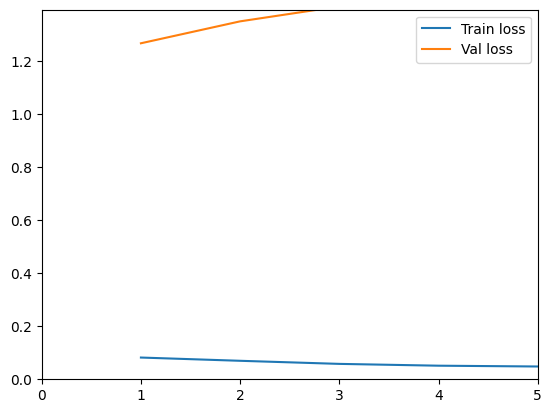

In [4]:
train_losses, val_losses = train(model=TCmodel, train_loader=train_loader, val_loader=val_loader, optimizer=optim, criterion=criterion, device=device, epochs=50)

In [5]:
print(train_losses.min(), val_losses.max())

0.048186410229698 1.4714468295369747


In [6]:
test_losses = test(model=TCmodel, test_loader=test_loader, criterion=criterion, device=device)
print(test_losses)

1.4130307292165996
